In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from typing import Tuple
import torchvision.models as models
import torchvision.transforms as T
import numpy as np
import os
import torchvision.transforms.functional as TF
import random
from scipy.ndimage import rotate, median_filter, uniform_filter
import io
import cv2
from skimage.metrics import structural_similarity as ssim

print("Cuda available :", torch.cuda.is_available())
print("cuda version : ", torch.backends.cudnn.version())
print("No of GPU : ", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"Device {i} Name: ", torch.cuda.get_device_name(i))


# Get image inputs and preprocess
def preprocess_images(image_path1: str, image_path2: str, image_path3: str, image_path4: str, height_width: int = 256) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    transform = transforms.Compose([
        transforms.Resize((height_width, height_width)),
        transforms.ToTensor()
    ])
    image1 = Image.open(image_path1).convert("RGB")
    image2 = Image.open(image_path2).convert("RGB")
    image3 = Image.open(image_path3).convert("RGB")
    image4 = Image.open(image_path4).convert("RGB")
    # print("Shape of Image 1: ", image1.size)
    image1 = transform(image1)
    image2 = transform(image2)
    image3 = transform(image3)
    image4 = transform(image4)
    # print("Shape of Reshaped Image 1: ", image1.shape)
    return image1, image2, image3, image4

def show_image(image: torch.Tensor) -> None:
    image_np = image.squeeze().detach().numpy()
    image_np = image_np.transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    plt.imshow(image_np)
    plt.axis('off')

# Define a function to display an image on a given axis
def plot_image(ax, image: torch.Tensor, title: str = "", fontsize=8):
    image_np = image.squeeze().detach().numpy()
    image_np = image_np.transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    ax.imshow(image_np)
    ax.set_title(title, fontsize=fontsize)
    ax.axis('off')


# Error value
def calculate_mean_pixel_difference(image1: torch.Tensor, image2: torch.Tensor, absolute: bool = True) -> float:
    if image1.shape != image2.shape:
        raise ValueError("Error: Tensors must have the same shape.")
    difference = image1 - image2
    if absolute:
        mean_difference = torch.mean(torch.abs(difference))
    else:
        mean_difference = torch.mean(difference ** 2)
    return mean_difference.item()  


### PIXEL WISE Fusion
# Function to combine images pixel-wise with alternating pattern
def combine_images_pixel_wise(img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
    combined_image_pixel_wise = torch.zeros_like(img1)
    combined_image_pixel_wise[:, 0::2, ::2] = img1[:, 0::2, ::2]    # img1 even rows, even cols
    combined_image_pixel_wise[:, 0::2, 1::2] = img2[:, 0::2, 1::2]  # img2 even rows, odd cols
    combined_image_pixel_wise[:, 1::2, ::2] = img2[:, 1::2, ::2]    # img2 odd rows, even cols
    combined_image_pixel_wise[:, 1::2, 1::2] = img1[:, 1::2, 1::2]  # img1 odd rows, odd cols
    return combined_image_pixel_wise
# Function to reconstruct images from combined image
def reconstruct_images_pixel_wise(combined_image_pixel_wise: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    img1_reconstructed_pixel_wise = torch.zeros_like(combined_image_pixel_wise)
    img2_reconstructed_pixel_wise = torch.zeros_like(combined_image_pixel_wise)
    img1_reconstructed_pixel_wise[:, 0::2, ::2] = combined_image_pixel_wise[:, 0::2, ::2]
    img2_reconstructed_pixel_wise[:, 0::2, 1::2] = combined_image_pixel_wise[:, 0::2, 1::2]
    img2_reconstructed_pixel_wise[:, 1::2, ::2] = combined_image_pixel_wise[:, 1::2, ::2]
    img1_reconstructed_pixel_wise[:, 1::2, 1::2] = combined_image_pixel_wise[:, 1::2, 1::2]
    return img1_reconstructed_pixel_wise, img2_reconstructed_pixel_wise
# 4NN Refinement
def replace_missing_pixels_with_neighbors(image_tensor: torch.Tensor, secret_image_number: int) -> torch.Tensor:
    channels, height, width = image_tensor.shape
    filled_image = image_tensor.clone()
    for i in range(height):
        for j in range(width):
            if secret_image_number == 1:
                if (i % 2 == 0 and j % 2 == 0) or (i % 2 == 1 and j % 2 == 1):
                    continue  
            elif secret_image_number == 2:
                if (i % 2 == 0 and j % 2 == 1) or (i % 2 == 1 and j % 2 == 0):
                    continue  
            if torch.all(filled_image[:, i, j] == 0):
                neighbors = []
                if i - 1 >= 0 and torch.any(filled_image[:, i - 1, j] != 0):
                    neighbors.append(filled_image[:, i - 1, j])
                if i + 1 < height and torch.any(filled_image[:, i + 1, j] != 0):
                    neighbors.append(filled_image[:, i + 1, j])
                if j - 1 >= 0 and torch.any(filled_image[:, i, j - 1] != 0):
                    neighbors.append(filled_image[:, i, j - 1])
                if j + 1 < width and torch.any(filled_image[:, i, j + 1] != 0):
                    neighbors.append(filled_image[:, i, j + 1])
                if neighbors:
                    filled_image[:, i, j] = torch.mean(torch.stack(neighbors), dim=0)
    return filled_image


### LSB Manipulatioin Fusion
# Function to load and preprocess images
def load_image_msb(image_path: str, size=(256, 256)) -> torch.Tensor:
    image = Image.open(image_path).convert("RGB")  
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),  
    ])
    image_tensor = transform(image) * 255  
    return image_tensor.to(torch.uint8)
# Function to display an image
def plot_image_msb(ax, image: torch.Tensor, title: str):
    image_np = image.permute(1, 2, 0).byte().numpy()  
    ax.imshow(image_np)
    ax.set_title(title)
    ax.axis('off')  
    
# Combining images using LSB
def combine_images_pixel_wise_msb(img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
    img1 = img1.to(torch.uint8)
    img2 = img2.to(torch.uint8)
    combined_image_pixel_wise = torch.zeros_like(img1)
    img1_msb = img1 & 0xF0  
    img2_msb = img2 & 0xF0 
    combined_image_pixel_wise[:, ::2, ::2] = (img1_msb[:, ::2, ::2] | (img2_msb[:, ::2, ::2] >> 4))      # even row, even col
    combined_image_pixel_wise[:, ::2, 1::2] = (img2_msb[:, ::2, 1::2] | (img1_msb[:, ::2, 1::2] >> 4))   # even row, odd col
    combined_image_pixel_wise[:, 1::2, ::2] = (img2_msb[:, 1::2, ::2] | (img1_msb[:, 1::2, ::2] >> 4))   # odd row, even col
    combined_image_pixel_wise[:, 1::2, 1::2] = (img1_msb[:, 1::2, 1::2] | (img2_msb[:, 1::2, 1::2] >> 4))# odd row, odd col
    return combined_image_pixel_wise
# Reconstructing images from combined image
def reconstruct_images_pixel_wise_msb(combined_image_pixel_wise: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    combined_image_pixel_wise = combined_image_pixel_wise.to(torch.uint8)
    img1_reconstructed_pixel_wise = torch.zeros_like(combined_image_pixel_wise)
    img2_reconstructed_pixel_wise = torch.zeros_like(combined_image_pixel_wise)
    img1_reconstructed_pixel_wise[:, ::2, ::2] = combined_image_pixel_wise[:, ::2, ::2] & 0xF0             # even row, even col
    img2_reconstructed_pixel_wise[:, ::2, ::2] = (combined_image_pixel_wise[:, ::2, ::2] & 0x0F) << 4      # even row, even col
    img2_reconstructed_pixel_wise[:, ::2, 1::2] = combined_image_pixel_wise[:, ::2, 1::2] & 0xF0           # even row, odd col
    img1_reconstructed_pixel_wise[:, ::2, 1::2] = (combined_image_pixel_wise[:, ::2, 1::2] & 0x0F) << 4    # even row, odd col
    img2_reconstructed_pixel_wise[:, 1::2, ::2] = combined_image_pixel_wise[:, 1::2, ::2] & 0xF0           # odd row, even col
    img1_reconstructed_pixel_wise[:, 1::2, ::2] = (combined_image_pixel_wise[:, 1::2, ::2] & 0x0F) << 4    # odd row, even col
    img1_reconstructed_pixel_wise[:, 1::2, 1::2] = combined_image_pixel_wise[:, 1::2, 1::2] & 0xF0         # odd row, odd col
    img2_reconstructed_pixel_wise[:, 1::2, 1::2] = (combined_image_pixel_wise[:, 1::2, 1::2] & 0x0F) << 4  # odd row, odd col
    return img1_reconstructed_pixel_wise, img2_reconstructed_pixel_wise


#Arnold and Revers Arnold
def arnold_transform_tensor(image_tensor: torch.Tensor, iterations: int = 1) -> torch.Tensor:
    N = image_tensor.shape[1]  
    transformed_image = image_tensor.clone()
    for _ in range(iterations):
        new_image = torch.zeros_like(transformed_image)
        for x in range(N):
            for y in range(N):
                x_new = (x + y) % N
                y_new = (x + 2 * y) % N
                new_image[:, x_new, y_new] = transformed_image[:, x, y]
        transformed_image = new_image
    return transformed_image
def reverse_arnold_transform_tensor(image_tensor: torch.Tensor, iterations: int = 1) -> torch.Tensor:
    N = image_tensor.shape[1]  
    transformed_image = image_tensor.clone()
    for _ in range(iterations):
        new_image = torch.zeros_like(transformed_image)
        for x in range(N):
            for y in range(N):
                x_new = (2 * x - y) % N
                y_new = (-x + y) % N
                new_image[:, x_new, y_new] = transformed_image[:, x, y]
        transformed_image = new_image
    return transformed_image


# Steganographic Key generaion
def string_to_number(text):
    return '0000'+str(abs(hash(text)) % 1_000)

def seperate_key(key):
    if len(str(key)) != 7:
        raise ValueError("Key must be a 7-digit integer.")
    key_str = str(key)
    sk1, sk2, sk3, sk4, sk5, sk6, sk7 = map(int, key_str)
    return sk1, sk2, sk3, sk4, sk5, sk6, sk7


Cuda available : True
cuda version :  8907
No of GPU :  1
Device 0 Name:  NVIDIA GeForce GTX 1650 with Max-Q Design


In [23]:
# ENCODE IMAGE
def encode_images(img1, img2, img3, img4, encode_secret_key):
    generated_number = string_to_number(encode_secret_key)
    sk1, sk2, sk3, sk4, sk5, sk6, sk7 = seperate_key(generated_number)
    scr_img_1 = arnold_transform_tensor(img1, sk1)
    scr_img_2 = arnold_transform_tensor(img2, sk2)
    scr_img_3 = arnold_transform_tensor(img3, sk3)
    scr_img_4 = arnold_transform_tensor(img4, sk4)
    combined_image_pixel_wise_1 = combine_images_pixel_wise(scr_img_1, scr_img_2)
    combined_image_pixel_wise_2 = combine_images_pixel_wise(scr_img_3, scr_img_4)
    scr_combined_image_pixel_wise_1 = arnold_transform_tensor(combined_image_pixel_wise_1, sk5)
    scr_combined_image_pixel_wise_2 = arnold_transform_tensor(combined_image_pixel_wise_2, sk6)
    combined_image_lsb = combine_images_pixel_wise_msb((scr_combined_image_pixel_wise_1*255).to(torch.uint8),(scr_combined_image_pixel_wise_2*255).to(torch.uint8))
    scrambled_image = arnold_transform_tensor(combined_image_lsb,sk7)
    return scr_img_1, scr_img_2, scr_img_3, scr_img_4, combined_image_pixel_wise_1, combined_image_pixel_wise_2, scr_combined_image_pixel_wise_1, scr_combined_image_pixel_wise_2, combined_image_lsb, scrambled_image

# DECODE
def decode_images(scrambled_image, decode_secret_key):
    generated_number = string_to_number(decode_secret_key)
    sk1, sk2, sk3, sk4, sk5, sk6, sk7 = seperate_key(generated_number)
    descrambled_image = reverse_arnold_transform_tensor(scrambled_image,sk7)
    img1_defused_lsb, img2_defused_lsb = reconstruct_images_pixel_wise_msb(descrambled_image)
    img1_defused_lsb = img1_defused_lsb.to(torch.float32) / 255.0
    img2_defused_lsb = img2_defused_lsb.to(torch.float32) / 255.0
    des_img1_defused_lsb = reverse_arnold_transform_tensor(img1_defused_lsb,sk5)
    des_img2_defused_lsb = reverse_arnold_transform_tensor(img2_defused_lsb,sk6)
    img1_reconstructed_pixel_wise, img2_reconstructed_pixel_wise = reconstruct_images_pixel_wise(des_img1_defused_lsb)
    img1_NN_refined_pixel_wise = replace_missing_pixels_with_neighbors(img1_reconstructed_pixel_wise, 1)
    img2_NN_refined_pixel_wise = replace_missing_pixels_with_neighbors(img2_reconstructed_pixel_wise, 2)
    des_img1_reconstructed_pixel_wise = reverse_arnold_transform_tensor(img1_NN_refined_pixel_wise,sk1)
    des_img2_reconstructed_pixel_wise = reverse_arnold_transform_tensor(img2_NN_refined_pixel_wise,sk2)
    img3_reconstructed_pixel_wise, img4_reconstructed_pixel_wise = reconstruct_images_pixel_wise(des_img2_defused_lsb)
    img3_NN_refined_pixel_wise = replace_missing_pixels_with_neighbors(img3_reconstructed_pixel_wise, 1)
    img4_NN_refined_pixel_wise = replace_missing_pixels_with_neighbors(img4_reconstructed_pixel_wise, 2)
    des_img3_reconstructed_pixel_wise = reverse_arnold_transform_tensor(img3_NN_refined_pixel_wise,sk3)
    des_img4_reconstructed_pixel_wise = reverse_arnold_transform_tensor(img4_NN_refined_pixel_wise,sk4)
    return descrambled_image, img1_defused_lsb, img2_defused_lsb, des_img1_defused_lsb, des_img2_defused_lsb, img1_reconstructed_pixel_wise, img2_reconstructed_pixel_wise, img3_reconstructed_pixel_wise, img4_reconstructed_pixel_wise, img1_NN_refined_pixel_wise, img2_NN_refined_pixel_wise, img3_NN_refined_pixel_wise, img4_NN_refined_pixel_wise, des_img1_reconstructed_pixel_wise, des_img2_reconstructed_pixel_wise, des_img3_reconstructed_pixel_wise, des_img4_reconstructed_pixel_wise


In [24]:
def scaling_attack_old(image, scale_factor=0.5):
    H, W = image.shape[1:]
    downscaled = TF.resize(image, [int(H * scale_factor), int(W * scale_factor)])
    upscaled = TF.resize(downscaled, [H, W])
    return upscaled

def scaling_attack(image, target_resolution):
    return TF.resize(image, target_resolution)


In [25]:
def rotational_attack(image, angle=90):
    return TF.rotate(image, angle, interpolation=TF.InterpolationMode.BILINEAR)

In [26]:
def gaussian_noise_attack(image, mean=0.0, std=0.05):
    if image.dtype == torch.uint8:
        image = image.float() / 255.0  # Normalize to [0, 1]
    noise = torch.randn_like(image) * std + mean
    noisy_image = torch.clamp(image + noise, 0.0, 1.0)
    return (noisy_image * 255).byte()

In [27]:
def salt_and_pepper_noise_attack(image, amount=0.01):
    noisy = image.clone()
    num_pixels = int(amount * image.numel())

    # Salt
    coords = [torch.randint(0, s, (num_pixels,)) for s in image.shape]
    noisy[coords[0], coords[1], coords[2]] = 1.0

    # Pepper
    coords = [torch.randint(0, s, (num_pixels,)) for s in image.shape]
    noisy[coords[0], coords[1], coords[2]] = 0.0

    return noisy

In [28]:
def speckle_noise_attack(image, std=0.1):
    if image.dtype == torch.uint8:
        image = image.float() / 255.0
    noise = torch.randn_like(image) * std
    noisy_image = image + image * noise
    noisy_image = torch.clamp(noisy_image, 0.0, 1.0)
    return (noisy_image * 255).byte()

In [29]:
def median_filter_attack(image, kernel_size=3):
    filtered = torch.tensor(np.stack([
        median_filter(image[c].cpu().numpy(), size=kernel_size)
        for c in range(3)
    ]), dtype=image.dtype)
    return filtered.to(image.device)

In [30]:
def mean_filter_attack(image, kernel_size=3):
    filtered = torch.tensor(np.stack([
        uniform_filter(image[c].cpu().numpy(), size=kernel_size)
        for c in range(3)
    ]), dtype=image.dtype)
    return filtered.to(image.device)

In [31]:
def flip_attack(image, direction='horizontal'):
    if direction == 'horizontal':
        return torch.flip(image, dims=[2])  # Flip width
    elif direction == 'vertical':
        return torch.flip(image, dims=[1])  # Flip height
    else:
        raise ValueError("direction must be 'horizontal' or 'vertical'")


In [32]:
# def jpeg_compression_attack(image, quality=50):
#     image_pil = TF.to_pil_image(image.cpu().detach().clamp(0, 1))
#     buffer = io.BytesIO()
#     image_pil.save(buffer, format='JPEG', quality=quality)
#     compressed = Image.open(buffer)
#     return TF.to_tensor(compressed)

def jpeg_compression_attack(image, quality=50):
    original_dtype = image.dtype
    is_byte = original_dtype == torch.uint8
    if is_byte:
        image_pil = TF.to_pil_image(image)
    else:
        image_pil = TF.to_pil_image(image.clamp(0, 1))
    buffer = io.BytesIO()
    image_pil.save(buffer, format='JPEG', quality=quality)
    buffer.seek(0)  
    compressed = Image.open(buffer)
    compressed_tensor = TF.to_tensor(compressed)
    if is_byte:
        compressed_tensor = (compressed_tensor * 255).round().clamp(0, 255).to(torch.uint8)
    return compressed_tensor

In [33]:
def crop_pad_attack(image, crop_frac=0.8):
    C, H, W = image.shape
    new_H, new_W = int(H * crop_frac), int(W * crop_frac)
    top = (H - new_H) // 2
    left = (W - new_W) // 2
    cropped = image[:, top:top+new_H, left:left+new_W]
    return TF.resize(cropped, [H, W])

In [34]:
# def motion_blur_attack(image, kernel_size=15):
#     image_np = TF.to_pil_image(image).convert("RGB")
#     image_np = np.array(image_np)
#     # Create motion blur kernel
#     kernel = np.zeros((kernel_size, kernel_size))
#     kernel[int((kernel_size-1)/2), :] = np.ones(kernel_size)
#     kernel /= kernel_size
#     blurred = cv2.filter2D(image_np, -1, kernel)
#     return TF.to_tensor(blurred)

def motion_blur_attack(image, kernel_size=15):
    original_dtype = image.dtype
    is_byte = original_dtype == torch.uint8
    if is_byte:
        image_np = TF.to_pil_image(image)
    else:
        image_np = TF.to_pil_image(image.clamp(0, 1))
    image_np = np.array(image_np)
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel /= kernel_size
    blurred = cv2.filter2D(image_np, -1, kernel)
    tensor_blurred = TF.to_tensor(blurred)
    if is_byte:
        tensor_blurred = (tensor_blurred * 255).round().clamp(0, 255).to(torch.uint8)
    return tensor_blurred

In [35]:
def color_jitter_attack(image, brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1):
    transform = T.ColorJitter(brightness=brightness, contrast=contrast,
                               saturation=saturation, hue=hue)
    return transform(image)

In [36]:
def channel_shuffle_attack(image):
    idx = torch.randperm(3)
    return image[idx]

In [37]:
def random_pixel_deletion_attack(image, drop_rate=0.5):
    C, H, W = image.shape
    mask = torch.rand((1, H, W), device=image.device) > drop_rate
    return image * mask

In [38]:
def random_pixel_modification_attack(image, mod_rate=0.5):
    original_dtype = image.dtype
    is_byte = original_dtype == torch.uint8
    if is_byte:
        image = image.float() / 255.0
    C, H, W = image.shape
    mask = (torch.rand(1, H, W, device=image.device) < mod_rate).expand_as(image)
    random_pixels = torch.rand_like(image)
    modified = torch.where(mask, random_pixels, image)
    if is_byte:
        modified = (modified * 255).round().clamp(0, 255).to(torch.uint8)
    return modified

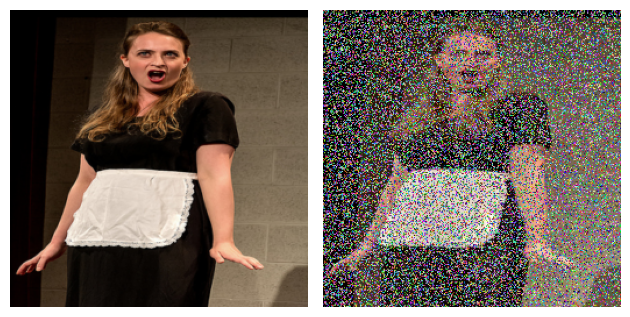

In [41]:
image_path1 = './original_images/fuse1.JPEG'
image_path2 = './original_images/fuse2.JPEG'
image_path3 = './original_images/fuse3.JPEG'
image_path4 = './original_images/fuse4.JPEG'

img1, img2, img3, img4 = preprocess_images(image_path1, image_path2, image_path3, image_path4)
attacked_image1 = random_pixel_modification_attack(img2)

fig, axes = plt.subplots(1, 2)
plot_image(axes[0], img2)
plot_image(axes[1], attacked_image1)
plt.tight_layout()
plt.show()

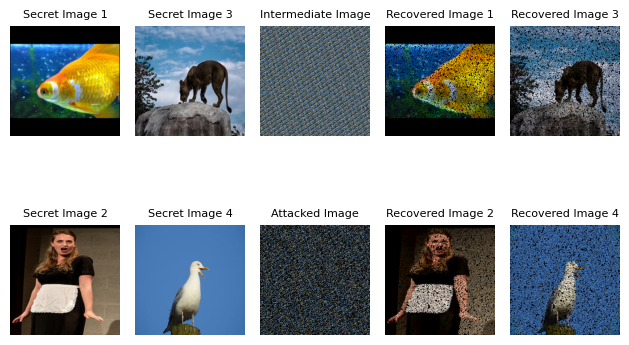

In [45]:
encode_secret_key = '0000222'
decode_secret_key = '0000222'

image_path1 = './original_images/fuse1.JPEG'
image_path2 = './original_images/fuse2.JPEG'
image_path3 = './original_images/fuse3.JPEG'
image_path4 = './original_images/fuse4.JPEG'
img1, img2, img3, img4 = preprocess_images(image_path1, image_path2, image_path3, image_path4)

scr_img_1, scr_img_2, scr_img_3, scr_img_4, combined_image_pixel_wise_1, combined_image_pixel_wise_2, scr_combined_image_pixel_wise_1, scr_combined_image_pixel_wise_2, combined_image_lsb, scrambled_image = encode_images(img1, img2, img3, img4, encode_secret_key)

# scrambled_scaled = scaling_attack(scrambled_image, (128, 128))
# attacked_image = scaling_attack(scrambled_scaled, (256, 256))

# scrambled_scaled = scaling_attack(scrambled_image, (512, 512))
# attacked_image = scaling_attack(scrambled_scaled, (256, 256))

# attacked_image = rotational_attack(scrambled_image, 90)

# attacked_image = rotational_attack(scrambled_image, 180)

# attacked_image = gaussian_noise_attack(scrambled_image)

# attacked_image = salt_and_pepper_noise_attack(scrambled_image)

# attacked_image = speckle_noise_attack(scrambled_image)

# attacked_image = median_filter_attack(scrambled_image)

# attacked_image = mean_filter_attack(scrambled_image)

# attacked_image = flip_attack(scrambled_image, 'vertical')

# attacked_image = flip_attack(scrambled_image)

# attacked_image = jpeg_compression_attack(scrambled_image)

# attacked_image = crop_pad_attack(scrambled_image)

# attacked_image = motion_blur_attack(scrambled_image)

# attacked_image = color_jitter_attack(scrambled_image)

# attacked_image = channel_shuffle_attack(scrambled_image)

attacked_image = random_pixel_deletion_attack(scrambled_image)

# attacked_image = random_pixel_modification_attack(scrambled_image)

descrambled_image, img1_defused_lsb, img2_defused_lsb, des_img1_defused_lsb, des_img2_defused_lsb, img1_reconstructed_pixel_wise, img2_reconstructed_pixel_wise, img3_reconstructed_pixel_wise, img4_reconstructed_pixel_wise, img1_NN_refined_pixel_wise, img2_NN_refined_pixel_wise, img3_NN_refined_pixel_wise, img4_NN_refined_pixel_wise, des_img1_reconstructed_pixel_wise, des_img2_reconstructed_pixel_wise, des_img3_reconstructed_pixel_wise, des_img4_reconstructed_pixel_wise = decode_images(attacked_image, decode_secret_key)


fig, axes = plt.subplots(2, 5)

plot_image(axes[0][0], img1, "Secret Image 1")
plot_image(axes[1][0], img2, "Secret Image 2")
plot_image(axes[0][1], img3, "Secret Image 3")
plot_image(axes[1][1], img4, "Secret Image 4")

plot_image(axes[0][2], scrambled_image, "Intermediate Image")
plot_image(axes[1][2], attacked_image, "Attacked Image")

plot_image(axes[0][3], img1_NN_refined_pixel_wise, "Recovered Image 1")
plot_image(axes[1][3], img2_NN_refined_pixel_wise, "Recovered Image 2")
plot_image(axes[0][4], img3_NN_refined_pixel_wise, "Recovered Image 3")
plot_image(axes[1][4], img4_NN_refined_pixel_wise, "Recovered Image 4")

# Hide the empty subplots
for ax in axes.flat:
    if not ax.has_data():
        ax.axis('off')  # Turn off the axis

plt.tight_layout()
plt.show()

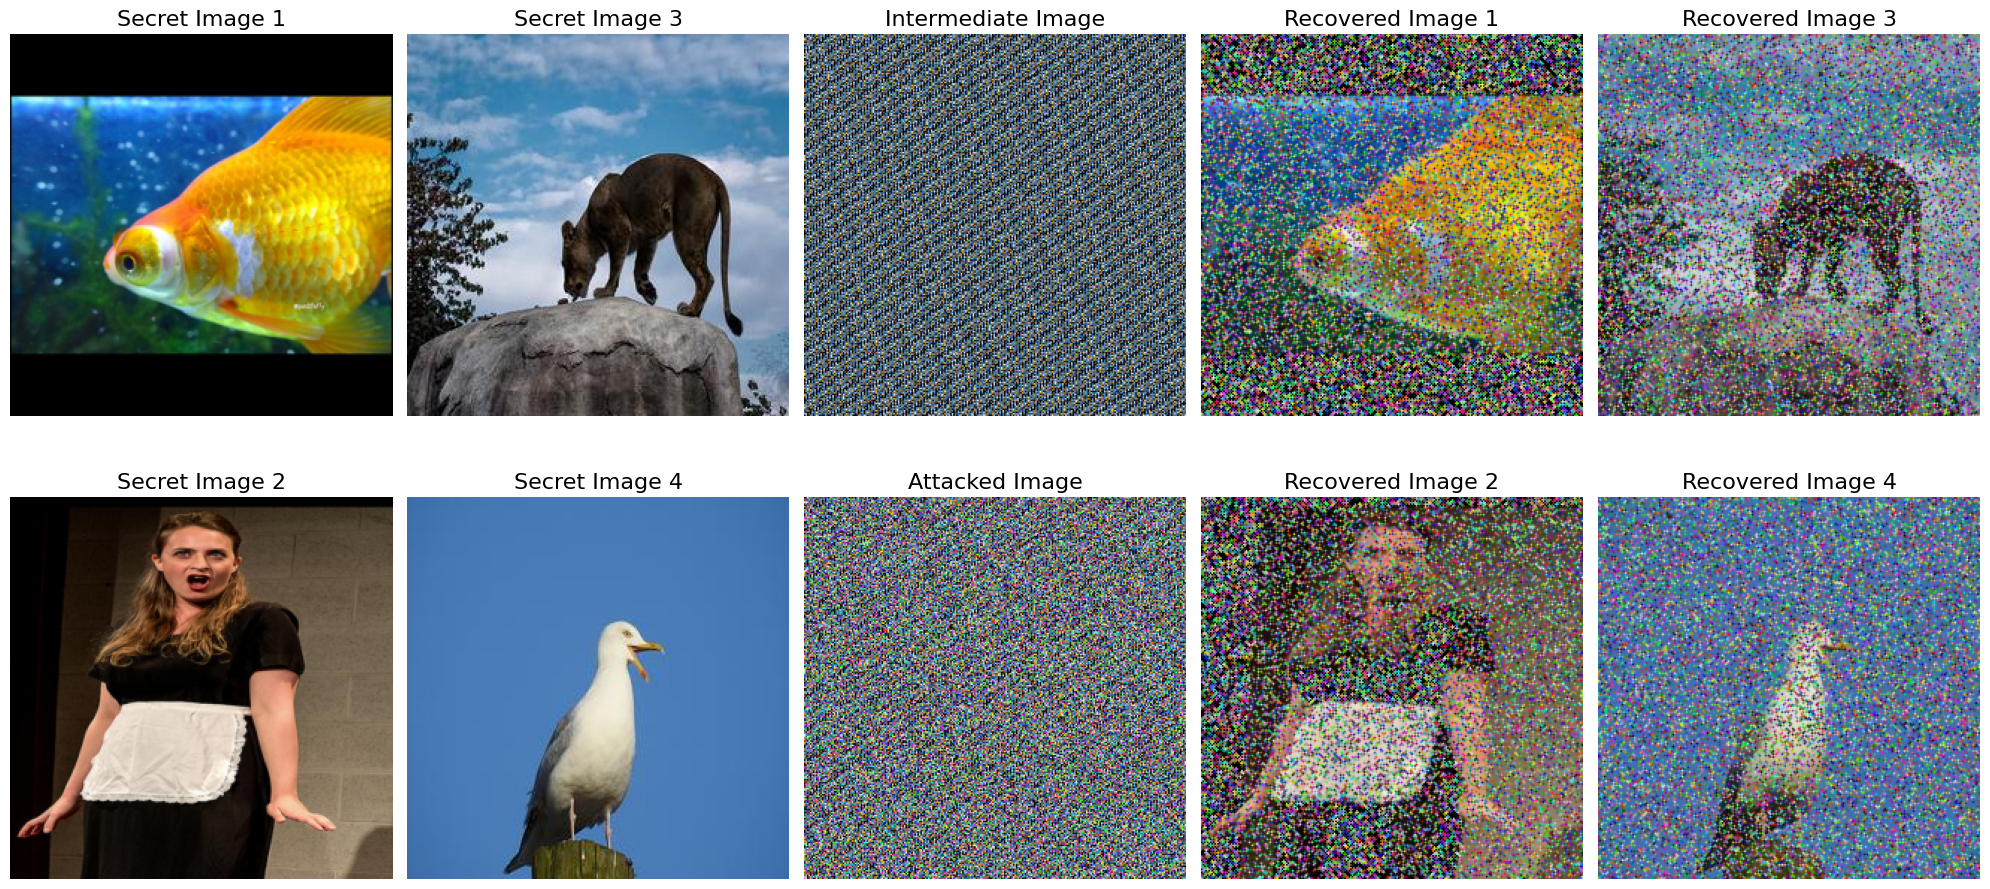

In [76]:
encode_secret_key = '0000222'
decode_secret_key = '0000222'

image_path1 = './original_images/fuse1.JPEG'
image_path2 = './original_images/fuse2.JPEG'
image_path3 = './original_images/fuse3.JPEG'
image_path4 = './original_images/fuse4.JPEG'
img1, img2, img3, img4 = preprocess_images(image_path1, image_path2, image_path3, image_path4)

scr_img_1, scr_img_2, scr_img_3, scr_img_4, combined_image_pixel_wise_1, combined_image_pixel_wise_2, scr_combined_image_pixel_wise_1, scr_combined_image_pixel_wise_2, combined_image_lsb, scrambled_image = encode_images(img1, img2, img3, img4, encode_secret_key)

# scrambled_scaled = scaling_attack(scrambled_image, (128, 128))
# attacked_image = scaling_attack(scrambled_scaled, (256, 256))

# scrambled_scaled = scaling_attack(scrambled_image, (512, 512))
# attacked_image = scaling_attack(scrambled_scaled, (256, 256))

# attacked_image = rotational_attack(scrambled_image, 90)

# attacked_image = rotational_attack(scrambled_image, 180)

# attacked_image = gaussian_noise_attack(scrambled_image)

# attacked_image = salt_and_pepper_noise_attack(scrambled_image)

# attacked_image = speckle_noise_attack(scrambled_image)

# attacked_image = median_filter_attack(scrambled_image)

# attacked_image = mean_filter_attack(scrambled_image)

# attacked_image = flip_attack(scrambled_image, 'vertical')

# attacked_image = flip_attack(scrambled_image)

# attacked_image = jpeg_compression_attack(scrambled_image)

# attacked_image = crop_pad_attack(scrambled_image)

# attacked_image = motion_blur_attack(scrambled_image)

# attacked_image = color_jitter_attack(scrambled_image)

# attacked_image = channel_shuffle_attack(scrambled_image)

# attacked_image = random_pixel_deletion_attack(scrambled_image)

attacked_image = random_pixel_modification_attack(scrambled_image)

descrambled_image, img1_defused_lsb, img2_defused_lsb, des_img1_defused_lsb, des_img2_defused_lsb, img1_reconstructed_pixel_wise, img2_reconstructed_pixel_wise, img3_reconstructed_pixel_wise, img4_reconstructed_pixel_wise, img1_NN_refined_pixel_wise, img2_NN_refined_pixel_wise, img3_NN_refined_pixel_wise, img4_NN_refined_pixel_wise, des_img1_reconstructed_pixel_wise, des_img2_reconstructed_pixel_wise, des_img3_reconstructed_pixel_wise, des_img4_reconstructed_pixel_wise = decode_images(attacked_image, decode_secret_key)


fig, axes = plt.subplots(2, 5, figsize=(20, 10))

plot_image(axes[0][0], img1, "Secret Image 1", fontsize=16)
plot_image(axes[1][0], img2, "Secret Image 2", fontsize=16)
plot_image(axes[0][1], img3, "Secret Image 3", fontsize=16)
plot_image(axes[1][1], img4, "Secret Image 4", fontsize=16)

plot_image(axes[0][2], scrambled_image, "Intermediate Image", fontsize=16)
plot_image(axes[1][2], attacked_image, "Attacked Image", fontsize=16)

plot_image(axes[0][3], img1_NN_refined_pixel_wise, "Recovered Image 1", fontsize=16)
plot_image(axes[1][3], img2_NN_refined_pixel_wise, "Recovered Image 2", fontsize=16)
plot_image(axes[0][4], img3_NN_refined_pixel_wise, "Recovered Image 3", fontsize=16)
plot_image(axes[1][4], img4_NN_refined_pixel_wise, "Recovered Image 4", fontsize=16)

# Hide the empty subplots
for ax in axes.flat:
    if not ax.has_data():
        ax.axis('off')  # Turn off the axis

plt.tight_layout()
plt.show()

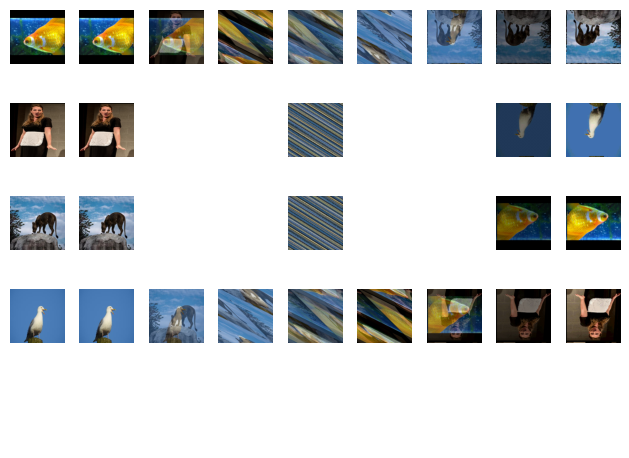

In [ ]:
fig, axes = plt.subplots(5, 9)

plot_image(axes[0][0], img1)
plot_image(axes[1][0], img2)
plot_image(axes[2][0], img3)
plot_image(axes[3][0], img4)

plot_image(axes[0][1], scr_img_1)
plot_image(axes[1][1], scr_img_2)
plot_image(axes[2][1], scr_img_3)
plot_image(axes[3][1], scr_img_4)

plot_image(axes[0][2], combined_image_pixel_wise_1)
plot_image(axes[3][2], combined_image_pixel_wise_2)

plot_image(axes[0][3], scr_combined_image_pixel_wise_1)
plot_image(axes[3][3], scr_combined_image_pixel_wise_2)

plot_image(axes[0][4], combined_image_lsb)
plot_image(axes[1][4], scrambled_image)
plot_image(axes[2][4], attacked_image)
plot_image(axes[3][4], descrambled_image)

plot_image(axes[0][5], img1_defused_lsb)
plot_image(axes[3][5], img2_defused_lsb)

plot_image(axes[0][6], des_img1_defused_lsb)
plot_image(axes[3][6], des_img2_defused_lsb)

plot_image(axes[0][7], img1_reconstructed_pixel_wise)
plot_image(axes[1][7], img2_reconstructed_pixel_wise)
plot_image(axes[2][7], img3_reconstructed_pixel_wise)
plot_image(axes[3][7], img4_reconstructed_pixel_wise)

plot_image(axes[0][8], img1_NN_refined_pixel_wise)
plot_image(axes[1][8], img2_NN_refined_pixel_wise)
plot_image(axes[2][8], img3_NN_refined_pixel_wise)
plot_image(axes[3][8], img4_NN_refined_pixel_wise)

# Hide the empty subplots
for ax in axes.flat:
    if not ax.has_data():
        ax.axis('off')  # Turn off the axis

plt.tight_layout()
plt.show()

In [27]:
def process_image_sets(folder_path, num_sets, encode_secret_key, decode_secret_key):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.JPEG') or f.endswith('.jpg') or f.endswith('.png')]
    
    if len(image_files) < 4:
        print("Not enough images in the folder.")
        return

    # Initialize total errors for each image
    total_img1_diff = 0
    total_img2_diff = 0
    total_img3_diff = 0
    total_img4_diff = 0
    
    for set_idx in range(num_sets):
        selected_images = random.sample(image_files, 4)
        image_paths = [os.path.join(folder_path, img) for img in selected_images]
        img1, img2, img3, img4 = preprocess_images(*image_paths)

        # Encoding step
        scr_img_1, scr_img_2, scr_img_3, scr_img_4, combined_image_pixel_wise_1, combined_image_pixel_wise_2, \
        scr_combined_image_pixel_wise_1, scr_combined_image_pixel_wise_2, combined_image_lsb, scrambled_image = encode_images(img1, img2, img3, img4, encode_secret_key)

        # Attacking the image
        # attacked_image = salt_and_pepper_noise_attack(scrambled_image)

        # Decoding step
        descrambled_image, img1_defused_lsb, img2_defused_lsb, des_img1_defused_lsb, des_img2_defused_lsb, \
        img1_reconstructed_pixel_wise, img2_reconstructed_pixel_wise, img3_reconstructed_pixel_wise, img4_reconstructed_pixel_wise, \
        img1_NN_refined_pixel_wise, img2_NN_refined_pixel_wise, img3_NN_refined_pixel_wise, img4_NN_refined_pixel_wise, \
        des_img1_reconstructed_pixel_wise, des_img2_reconstructed_pixel_wise, des_img3_reconstructed_pixel_wise, des_img4_reconstructed_pixel_wise = decode_images(scrambled_image, decode_secret_key)

        img1_diff = calculate_mean_pixel_difference(img1, img1_NN_refined_pixel_wise)
        img2_diff = calculate_mean_pixel_difference(img2, img2_NN_refined_pixel_wise)
        img3_diff = calculate_mean_pixel_difference(img3, img3_NN_refined_pixel_wise)
        img4_diff = calculate_mean_pixel_difference(img4, img4_NN_refined_pixel_wise)

        # Print the total error for each image
        print("Index : ", set_idx)
        # print(f"Error for Image 1: {img1_diff:.6f}")
        # print(f"Error for Image 2: {img2_diff:.6f}")
        # print(f"Error for Image 3: {img3_diff:.6f}")
        # print(f"Error for Image 4: {img4_diff:.6f}")

        # Accumulate the total errors for each image
        total_img1_diff += img1_diff
        total_img2_diff += img2_diff
        total_img3_diff += img3_diff
        total_img4_diff += img4_diff
    
    # Calculate the average error for each image across all sets
    avg_img1_diff = total_img1_diff / num_sets
    avg_img2_diff = total_img2_diff / num_sets
    avg_img3_diff = total_img3_diff / num_sets
    avg_img4_diff = total_img4_diff / num_sets

    # Print the total error for each image
    print(f"Total Error for Image 1: {total_img1_diff:.6f}")
    print(f"Total Error for Image 2: {total_img2_diff:.6f}")
    print(f"Total Error for Image 3: {total_img3_diff:.6f}")
    print(f"Total Error for Image 4: {total_img4_diff:.6f}")

    # Print the total error for each image
    print(f"Average Error for Image 1: {avg_img1_diff:.6f}")
    print(f"Average Error for Image 2: {avg_img2_diff:.6f}")
    print(f"Average Error for Image 3: {avg_img3_diff:.6f}")
    print(f"Average Error for Image 4: {avg_img4_diff:.6f}")

# Example usage:
folder_path = './original_images'
num_sets = 100
encode_secret_key = 'hello'
decode_secret_key = 'hello'

process_image_sets(folder_path, num_sets, encode_secret_key, decode_secret_key)


Index :  0
Index :  1
Index :  2
Index :  3
Index :  4
Index :  5
Index :  6
Index :  7
Index :  8
Index :  9
Index :  10
Index :  11
Index :  12
Index :  13
Index :  14
Index :  15
Index :  16
Index :  17
Index :  18
Index :  19
Index :  20
Index :  21
Index :  22
Index :  23
Index :  24
Index :  25
Index :  26
Index :  27
Index :  28
Index :  29
Index :  30
Index :  31
Index :  32
Index :  33
Index :  34
Index :  35
Index :  36
Index :  37
Index :  38
Index :  39
Index :  40
Index :  41
Index :  42
Index :  43
Index :  44
Index :  45
Index :  46
Index :  47
Index :  48
Index :  49
Index :  50
Index :  51
Index :  52
Index :  53
Index :  54
Index :  55
Index :  56
Index :  57
Index :  58
Index :  59
Index :  60
Index :  61
Index :  62
Index :  63
Index :  64
Index :  65
Index :  66
Index :  67
Index :  68
Index :  69
Index :  70
Index :  71
Index :  72
Index :  73
Index :  74
Index :  75
Index :  76
Index :  77
Index :  78
Index :  79
Index :  80
Index :  81
Index :  82
Index :  83
In

In [42]:
def calculate_mse(img1, img2):
    return torch.mean((img1 - img2) ** 2).item()

def calculate_rmse(img1, img2):
    mse = calculate_mse(img1, img2)
    return np.sqrt(mse)

def calculate_psnr(img1, img2, max_val=1.0):
    mse = calculate_mse(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(max_val / np.sqrt(mse))

def calculate_ssim(img1, img2):
    # Convert to NumPy arrays and move channel to last dimension
    img1_np = TF.to_pil_image(img1.clamp(0, 1)).convert("RGB")
    img2_np = TF.to_pil_image(img2.clamp(0, 1)).convert("RGB")
    img1_np = np.array(img1_np)
    img2_np = np.array(img2_np)
    return ssim(img1_np, img2_np, data_range=1.0, multichannel=True)

In [32]:
def process_image_sets(folder_path, num_sets, encode_secret_key, decode_secret_key):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.JPEG') or f.endswith('.jpg') or f.endswith('.png')]
    
    if len(image_files) < 4:
        print("Not enough images in the folder.")
        return

    # Initialize total errors for each image
    total_img1_diff_mse = 0
    total_img2_diff_mse = 0
    total_img3_diff_mse = 0
    total_img4_diff_mse = 0

    total_img1_diff_rmse = 0
    total_img2_diff_rmse = 0
    total_img3_diff_rmse = 0
    total_img4_diff_rmse = 0

    total_img1_diff_psnr = 0
    total_img2_diff_psnr = 0
    total_img3_diff_psnr = 0
    total_img4_diff_psnr = 0

    # total_img1_diff_ssim = 0
    # total_img2_diff_ssim = 0
    # total_img3_diff_ssim = 0
    # total_img4_diff_ssim = 0
    
    for set_idx in range(num_sets):
        selected_images = random.sample(image_files, 4)
        image_paths = [os.path.join(folder_path, img) for img in selected_images]
        img1, img2, img3, img4 = preprocess_images(*image_paths)

        # Encoding step
        scr_img_1, scr_img_2, scr_img_3, scr_img_4, combined_image_pixel_wise_1, combined_image_pixel_wise_2, \
        scr_combined_image_pixel_wise_1, scr_combined_image_pixel_wise_2, combined_image_lsb, scrambled_image = encode_images(img1, img2, img3, img4, encode_secret_key)

        # Attacking the image
        # attacked_image = salt_and_pepper_noise_attack(scrambled_image)

        # Decoding step
        descrambled_image, img1_defused_lsb, img2_defused_lsb, des_img1_defused_lsb, des_img2_defused_lsb, \
        img1_reconstructed_pixel_wise, img2_reconstructed_pixel_wise, img3_reconstructed_pixel_wise, img4_reconstructed_pixel_wise, \
        img1_NN_refined_pixel_wise, img2_NN_refined_pixel_wise, img3_NN_refined_pixel_wise, img4_NN_refined_pixel_wise, \
        des_img1_reconstructed_pixel_wise, des_img2_reconstructed_pixel_wise, des_img3_reconstructed_pixel_wise, des_img4_reconstructed_pixel_wise = decode_images(scrambled_image, decode_secret_key)

        img1_diff_mse = calculate_mse(img1, img1_NN_refined_pixel_wise)
        img1_diff_rmse = calculate_rmse(img1, img1_NN_refined_pixel_wise)
        img1_diff_psnr = calculate_psnr(img1, img1_NN_refined_pixel_wise)
        # img1_diff_ssim = calculate_ssim(img1, img1_NN_refined_pixel_wise)

        img2_diff_mse = calculate_mse(img2, img2_NN_refined_pixel_wise)
        img2_diff_rmse = calculate_rmse(img2, img2_NN_refined_pixel_wise)
        img2_diff_psnr = calculate_psnr(img2, img2_NN_refined_pixel_wise)
        # img2_diff_ssim = calculate_ssim(img2, img2_NN_refined_pixel_wise)

        img3_diff_mse = calculate_mse(img3, img3_NN_refined_pixel_wise)
        img3_diff_rmse = calculate_rmse(img3, img3_NN_refined_pixel_wise)
        img3_diff_psnr = calculate_psnr(img3, img3_NN_refined_pixel_wise)
        # img3_diff_ssim = calculate_ssim(img3, img3_NN_refined_pixel_wise)

        img4_diff_mse = calculate_mse(img4, img4_NN_refined_pixel_wise)
        img4_diff_rmse = calculate_rmse(img4, img4_NN_refined_pixel_wise)
        img4_diff_psnr = calculate_psnr(img4, img4_NN_refined_pixel_wise)
        # img4_diff_ssim = calculate_ssim(img4, img4_NN_refined_pixel_wise)

        # Print the total error for each image
        print("Index : ", set_idx)
        # print(f"Error for Image 1: {img1_diff:.6f}")
        # print(f"Error for Image 2: {img2_diff:.6f}")
        # print(f"Error for Image 3: {img3_diff:.6f}")
        # print(f"Error for Image 4: {img4_diff:.6f}")

        # Accumulate the total errors for each image
        total_img1_diff_mse += img1_diff_mse
        total_img2_diff_mse += img2_diff_mse
        total_img3_diff_mse += img3_diff_mse
        total_img4_diff_mse += img4_diff_mse

        total_img1_diff_rmse += img1_diff_rmse
        total_img2_diff_rmse += img2_diff_rmse
        total_img3_diff_rmse += img3_diff_rmse
        total_img4_diff_rmse += img4_diff_rmse

        total_img1_diff_psnr += img1_diff_psnr
        total_img2_diff_psnr += img2_diff_psnr
        total_img3_diff_psnr += img3_diff_psnr
        total_img4_diff_psnr += img4_diff_psnr

        # total_img1_diff_ssim += img1_diff_ssim
        # total_img2_diff_ssim += img2_diff_ssim
        # total_img3_diff_ssim += img3_diff_ssim
        # total_img4_diff_ssim += img4_diff_ssim
    
    # Calculate the average error for each image across all sets
    avg_img1_diff_mse = total_img1_diff_mse / num_sets
    avg_img2_diff_mse = total_img2_diff_mse / num_sets
    avg_img3_diff_mse = total_img3_diff_mse / num_sets
    avg_img4_diff_mse = total_img4_diff_mse / num_sets

    avg_img1_diff_rmse = total_img1_diff_rmse / num_sets
    avg_img2_diff_rmse = total_img2_diff_rmse / num_sets
    avg_img3_diff_rmse = total_img3_diff_rmse / num_sets
    avg_img4_diff_rmse = total_img4_diff_rmse / num_sets

    avg_img1_diff_psnr = total_img1_diff_psnr / num_sets
    avg_img2_diff_psnr = total_img2_diff_psnr / num_sets
    avg_img3_diff_psnr = total_img3_diff_psnr / num_sets
    avg_img4_diff_psnr = total_img4_diff_psnr / num_sets

    # avg_img1_diff_ssim = total_img1_diff_ssim / num_sets
    # avg_img2_diff_ssim = total_img2_diff_ssim / num_sets
    # avg_img3_diff_ssim = total_img3_diff_ssim / num_sets
    # avg_img4_diff_ssim = total_img4_diff_ssim / num_sets

    # Print the total error for each image
    # print(f"Total Error for Image 1: {total_img1_diff:.6f}")
    # print(f"Total Error for Image 2: {total_img2_diff:.6f}")
    # print(f"Total Error for Image 3: {total_img3_diff:.6f}")
    # print(f"Total Error for Image 4: {total_img4_diff:.6f}")

    # Print the total error for each image
    print(f"Average MSE Error for Image 1: {avg_img1_diff_mse:.6f}")
    print(f"Average MSE Error for Image 2: {avg_img2_diff_mse:.6f}")
    print(f"Average MSE Error for Image 3: {avg_img3_diff_mse:.6f}")
    print(f"Average MSE Error for Image 4: {avg_img4_diff_mse:.6f} \n")

    print(f"Average MSE Error for Image 1: {avg_img1_diff_rmse:.6f}")
    print(f"Average MSE Error for Image 2: {avg_img2_diff_rmse:.6f}")
    print(f"Average MSE Error for Image 3: {avg_img3_diff_rmse:.6f}")
    print(f"Average MSE Error for Image 4: {avg_img4_diff_rmse:.6f} \n")

    print(f"Average MSE Error for Image 1: {avg_img1_diff_psnr:.6f}")
    print(f"Average MSE Error for Image 2: {avg_img2_diff_psnr:.6f}")
    print(f"Average MSE Error for Image 3: {avg_img3_diff_psnr:.6f}")
    print(f"Average MSE Error for Image 4: {avg_img4_diff_psnr:.6f} \n")

    # print(f"Average MSE Error for Image 1: {avg_img1_diff_ssim:.6f}")
    # print(f"Average MSE Error for Image 2: {avg_img2_diff_ssim:.6f}")
    # print(f"Average MSE Error for Image 3: {avg_img3_diff_ssim:.6f}")
    # print(f"Average MSE Error for Image 4: {avg_img4_diff_ssim:.6f} \n")

# Example usage:
folder_path = './original_images'
num_sets = 100
encode_secret_key = 'hello'
decode_secret_key = 'hello'

process_image_sets(folder_path, num_sets, encode_secret_key, decode_secret_key)


Index :  0
Index :  1
Index :  2
Index :  3
Index :  4
Index :  5
Index :  6
Index :  7
Index :  8
Index :  9
Index :  10
Index :  11
Index :  12
Index :  13
Index :  14
Index :  15
Index :  16
Index :  17
Index :  18
Index :  19
Index :  20
Index :  21
Index :  22
Index :  23
Index :  24
Index :  25
Index :  26
Index :  27
Index :  28
Index :  29
Index :  30
Index :  31
Index :  32
Index :  33
Index :  34
Index :  35
Index :  36
Index :  37
Index :  38
Index :  39
Index :  40
Index :  41
Index :  42
Index :  43
Index :  44
Index :  45
Index :  46
Index :  47
Index :  48
Index :  49
Index :  50
Index :  51
Index :  52
Index :  53
Index :  54
Index :  55
Index :  56
Index :  57
Index :  58
Index :  59
Index :  60
Index :  61
Index :  62
Index :  63
Index :  64
Index :  65
Index :  66
Index :  67
Index :  68
Index :  69
Index :  70
Index :  71
Index :  72
Index :  73
Index :  74
Index :  75
Index :  76
Index :  77
Index :  78
Index :  79
Index :  80
Index :  81
Index :  82
Index :  83
In

In [43]:
def process_image_sets(folder_path, num_sets, encode_secret_key, decode_secret_key):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.JPEG') or f.endswith('.jpg') or f.endswith('.png')]
    
    if len(image_files) < 4:
        print("Not enough images in the folder.")
        return

    # Initialize total errors for each image
    # total_mse_error = 0
    total_rmse_error = 0
    # total_attacked_mse_error = 0
    total_attacked_rmse_error = 0
    # total_mse_error_upscale = 0
    # total_mse_error_downscale = 0
    # total_mse_error_rot90 = 0
    # total_mse_error_rot180 = 0
    # total_mse_error_crop_pad = 0
    # total_mse_error_fliph = 0
    # total_mse_error_flipv = 0
    # total_mse_error_gaussian = 0
    # total_mse_error_saltpepper = 0
    # total_mse_error_speckle = 0
    # total_mse_error_median = 0
    # total_mse_error_mean = 0
    # total_mse_error_motion = 0
    # total_mse_error_jpeg = 0
    # total_mse_error_colorjitter = 0
    # total_mse_error_channelshuffle = 0
    # total_mse_error_randdelete = 0
    # total_mse_error_randmodify = 0
    
    for set_idx in range(num_sets):
        selected_images = random.sample(image_files, 4)
        image_paths = [os.path.join(folder_path, img) for img in selected_images]
        img1, img2, img3, img4 = preprocess_images(*image_paths)

        # Encoding step
        scr_img_1, scr_img_2, scr_img_3, scr_img_4, combined_image_pixel_wise_1, combined_image_pixel_wise_2, \
        scr_combined_image_pixel_wise_1, scr_combined_image_pixel_wise_2, combined_image_lsb, scrambled_image = encode_images(img1, img2, img3, img4, encode_secret_key)

        # Decoding step
        descrambled_image, img1_defused_lsb, img2_defused_lsb, des_img1_defused_lsb, des_img2_defused_lsb, \
        img1_reconstructed_pixel_wise, img2_reconstructed_pixel_wise, img3_reconstructed_pixel_wise, img4_reconstructed_pixel_wise, \
        img1_NN_refined_pixel_wise, img2_NN_refined_pixel_wise, img3_NN_refined_pixel_wise, img4_NN_refined_pixel_wise, \
        des_img1_reconstructed_pixel_wise, des_img2_reconstructed_pixel_wise, des_img3_reconstructed_pixel_wise, des_img4_reconstructed_pixel_wise = decode_images(scrambled_image, decode_secret_key)

        # Attacking the image
        # scrambled_scaled = scaling_attack(scrambled_image, (128, 128))
        # attacked_image = scaling_attack(scrambled_scaled, (256, 256))

        # scrambled_scaled = scaling_attack(scrambled_image, (512, 512))
        # attacked_image = scaling_attack(scrambled_scaled, (256, 256))

        # attacked_image = rotational_attack(scrambled_image, 90)

        # attacked_image = rotational_attack(scrambled_image, 180)

        # attacked_image = gaussian_noise_attack(scrambled_image)

        # attacked_image = salt_and_pepper_noise_attack(scrambled_image)

        # attacked_image = speckle_noise_attack(scrambled_image)

        # attacked_image = median_filter_attack(scrambled_image)

        # attacked_image = mean_filter_attack(scrambled_image)

        # attacked_image = flip_attack(scrambled_image, 'vertical')

        # attacked_image = flip_attack(scrambled_image)

        # attacked_image = jpeg_compression_attack(scrambled_image)

        # attacked_image = crop_pad_attack(scrambled_image)

        # attacked_image = motion_blur_attack(scrambled_image)

        # attacked_image = color_jitter_attack(scrambled_image)

        # attacked_image = channel_shuffle_attack(scrambled_image)

        attacked_image = random_pixel_deletion_attack(scrambled_image)

        # attacked_image = random_pixel_modification_attack(scrambled_image)

        # Attacked Decoding step
        descrambled_image_attacked, img1_defused_lsb_attacked, img2_defused_lsb_attacked, des_img1_defused_lsb_attacked, des_img2_defused_lsb_attacked, \
        img1_reconstructed_pixel_wise_attacked, img2_reconstructed_pixel_wise_attacked, img3_reconstructed_pixel_wise_attacked, img4_reconstructed_pixel_wise_attacked, \
        img1_NN_refined_pixel_wise_attacked, img2_NN_refined_pixel_wise_attacked, img3_NN_refined_pixel_wise_attacked, img4_NN_refined_pixel_wise_attacked, \
        des_img1_reconstructed_pixel_wise_attacked, des_img2_reconstructed_pixel_wise_attacked, des_img3_reconstructed_pixel_wise_attacked, des_img4_reconstructed_pixel_wise = decode_images(attacked_image, decode_secret_key)

        # total_mse_error += calculate_mse(img1,img1_NN_refined_pixel_wise)
        # total_mse_error += calculate_mse(img2,img2_NN_refined_pixel_wise)
        # total_mse_error += calculate_mse(img3,img3_NN_refined_pixel_wise)
        # total_mse_error += calculate_mse(img4,img4_NN_refined_pixel_wise)

        # total_attacked_mse_error += calculate_mse(img1,img1_NN_refined_pixel_wise_attacked)
        # total_attacked_mse_error += calculate_mse(img2,img2_NN_refined_pixel_wise_attacked)
        # total_attacked_mse_error += calculate_mse(img3,img3_NN_refined_pixel_wise_attacked)
        # total_attacked_mse_error += calculate_mse(img4,img4_NN_refined_pixel_wise_attacked)

        total_rmse_error += calculate_rmse(img1,img1_NN_refined_pixel_wise)
        total_rmse_error += calculate_rmse(img2,img2_NN_refined_pixel_wise)
        total_rmse_error += calculate_rmse(img3,img3_NN_refined_pixel_wise)
        total_rmse_error += calculate_rmse(img4,img4_NN_refined_pixel_wise)

        total_attacked_rmse_error += calculate_rmse(img1,img1_NN_refined_pixel_wise_attacked)
        total_attacked_rmse_error += calculate_rmse(img2,img2_NN_refined_pixel_wise_attacked)
        total_attacked_rmse_error += calculate_rmse(img3,img3_NN_refined_pixel_wise_attacked)
        total_attacked_rmse_error += calculate_rmse(img4,img4_NN_refined_pixel_wise_attacked)

        # Print the total error for each image
        print("Index : ", set_idx)

    # Calculate the average error for each image across all sets
    # avg_mse_error = total_mse_error / num_sets
    # avg_attacked_mse_error = total_attacked_mse_error / num_sets
    avg_rmse_error = total_rmse_error / num_sets
    avg_attacked_rmse_error = total_attacked_rmse_error / num_sets


    # Print the total error for each image
    # print(f"\nAverage MSE Error : {avg_mse_error:.6f}")
    # print(f"Average rmse Error : {avg_attacked_mse_error:.6f}")
    print(f"Average rmse Error : {avg_rmse_error:.6f}")
    print(f"Average rmse Error Attacked : {avg_attacked_rmse_error:.6f} \n")

    # print(f"BER MSE Error : {(avg_attacked_mse_error/avg_mse_error):.6f}")
    print(f"BER rmse Error : {(avg_attacked_rmse_error/avg_rmse_error):.6f}")


# Example usage:
folder_path = './original_images'
num_sets = 10
encode_secret_key = '0000222'
decode_secret_key = '0000222'

process_image_sets(folder_path, num_sets, encode_secret_key, decode_secret_key)


Index :  0
Index :  1
Index :  2
Index :  3
Index :  4
Index :  5
Index :  6
Index :  7
Index :  8
Index :  9
Average rmse Error : 0.180350
Average rmse Error Attacked : 1.120781 

BER rmse Error : 6.214473


In [44]:
def process_image_sets(folder_path, num_sets, encode_secret_key, decode_secret_key):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.JPEG') or f.endswith('.jpg') or f.endswith('.png')]
    
    if len(image_files) < 4:
        print("Not enough images in the folder.")
        return

    # Initialize total errors for each image
    # total_mse_error = 0
    total_rmse_error = 0
    # total_attacked_mse_error = 0
    total_attacked_rmse_error = 0
    # total_mse_error_upscale = 0
    # total_mse_error_downscale = 0
    # total_mse_error_rot90 = 0
    # total_mse_error_rot180 = 0
    # total_mse_error_crop_pad = 0
    # total_mse_error_fliph = 0
    # total_mse_error_flipv = 0
    # total_mse_error_gaussian = 0
    # total_mse_error_saltpepper = 0
    # total_mse_error_speckle = 0
    # total_mse_error_median = 0
    # total_mse_error_mean = 0
    # total_mse_error_motion = 0
    # total_mse_error_jpeg = 0
    # total_mse_error_colorjitter = 0
    # total_mse_error_channelshuffle = 0
    # total_mse_error_randdelete = 0
    # total_mse_error_randmodify = 0
    
    for set_idx in range(num_sets):
        selected_images = random.sample(image_files, 4)
        image_paths = [os.path.join(folder_path, img) for img in selected_images]
        img1, img2, img3, img4 = preprocess_images(*image_paths)

        # Encoding step
        scr_img_1, scr_img_2, scr_img_3, scr_img_4, combined_image_pixel_wise_1, combined_image_pixel_wise_2, \
        scr_combined_image_pixel_wise_1, scr_combined_image_pixel_wise_2, combined_image_lsb, scrambled_image = encode_images(img1, img2, img3, img4, encode_secret_key)

        # Decoding step
        descrambled_image, img1_defused_lsb, img2_defused_lsb, des_img1_defused_lsb, des_img2_defused_lsb, \
        img1_reconstructed_pixel_wise, img2_reconstructed_pixel_wise, img3_reconstructed_pixel_wise, img4_reconstructed_pixel_wise, \
        img1_NN_refined_pixel_wise, img2_NN_refined_pixel_wise, img3_NN_refined_pixel_wise, img4_NN_refined_pixel_wise, \
        des_img1_reconstructed_pixel_wise, des_img2_reconstructed_pixel_wise, des_img3_reconstructed_pixel_wise, des_img4_reconstructed_pixel_wise = decode_images(scrambled_image, decode_secret_key)

        # Attacking the image
        # scrambled_scaled = scaling_attack(scrambled_image, (128, 128))
        # attacked_image = scaling_attack(scrambled_scaled, (256, 256))

        # scrambled_scaled = scaling_attack(scrambled_image, (512, 512))
        # attacked_image = scaling_attack(scrambled_scaled, (256, 256))

        # attacked_image = rotational_attack(scrambled_image, 90)

        # attacked_image = rotational_attack(scrambled_image, 180)

        # attacked_image = gaussian_noise_attack(scrambled_image)

        # attacked_image = salt_and_pepper_noise_attack(scrambled_image)

        # attacked_image = speckle_noise_attack(scrambled_image)

        # attacked_image = median_filter_attack(scrambled_image)

        # attacked_image = mean_filter_attack(scrambled_image)

        # attacked_image = flip_attack(scrambled_image, 'vertical')

        # attacked_image = flip_attack(scrambled_image)

        # attacked_image = jpeg_compression_attack(scrambled_image)

        # attacked_image = crop_pad_attack(scrambled_image)

        # attacked_image = motion_blur_attack(scrambled_image)

        # attacked_image = color_jitter_attack(scrambled_image)

        # attacked_image = channel_shuffle_attack(scrambled_image)

        # attacked_image = random_pixel_deletion_attack(scrambled_image)

        attacked_image = random_pixel_modification_attack(scrambled_image)

        # Attacked Decoding step
        descrambled_image_attacked, img1_defused_lsb_attacked, img2_defused_lsb_attacked, des_img1_defused_lsb_attacked, des_img2_defused_lsb_attacked, \
        img1_reconstructed_pixel_wise_attacked, img2_reconstructed_pixel_wise_attacked, img3_reconstructed_pixel_wise_attacked, img4_reconstructed_pixel_wise_attacked, \
        img1_NN_refined_pixel_wise_attacked, img2_NN_refined_pixel_wise_attacked, img3_NN_refined_pixel_wise_attacked, img4_NN_refined_pixel_wise_attacked, \
        des_img1_reconstructed_pixel_wise_attacked, des_img2_reconstructed_pixel_wise_attacked, des_img3_reconstructed_pixel_wise_attacked, des_img4_reconstructed_pixel_wise = decode_images(attacked_image, decode_secret_key)

        # total_mse_error += calculate_mse(img1,img1_NN_refined_pixel_wise)
        # total_mse_error += calculate_mse(img2,img2_NN_refined_pixel_wise)
        # total_mse_error += calculate_mse(img3,img3_NN_refined_pixel_wise)
        # total_mse_error += calculate_mse(img4,img4_NN_refined_pixel_wise)

        # total_attacked_mse_error += calculate_mse(img1,img1_NN_refined_pixel_wise_attacked)
        # total_attacked_mse_error += calculate_mse(img2,img2_NN_refined_pixel_wise_attacked)
        # total_attacked_mse_error += calculate_mse(img3,img3_NN_refined_pixel_wise_attacked)
        # total_attacked_mse_error += calculate_mse(img4,img4_NN_refined_pixel_wise_attacked)

        total_rmse_error += calculate_rmse(img1,img1_NN_refined_pixel_wise)
        total_rmse_error += calculate_rmse(img2,img2_NN_refined_pixel_wise)
        total_rmse_error += calculate_rmse(img3,img3_NN_refined_pixel_wise)
        total_rmse_error += calculate_rmse(img4,img4_NN_refined_pixel_wise)

        total_attacked_rmse_error += calculate_rmse(img1,img1_NN_refined_pixel_wise_attacked)
        total_attacked_rmse_error += calculate_rmse(img2,img2_NN_refined_pixel_wise_attacked)
        total_attacked_rmse_error += calculate_rmse(img3,img3_NN_refined_pixel_wise_attacked)
        total_attacked_rmse_error += calculate_rmse(img4,img4_NN_refined_pixel_wise_attacked)

        # Print the total error for each image
        print("Index : ", set_idx)

    # Calculate the average error for each image across all sets
    # avg_mse_error = total_mse_error / num_sets
    # avg_attacked_mse_error = total_attacked_mse_error / num_sets
    avg_rmse_error = total_rmse_error / num_sets
    avg_attacked_rmse_error = total_attacked_rmse_error / num_sets


    # Print the total error for each image
    # print(f"\nAverage MSE Error : {avg_mse_error:.6f}")
    # print(f"Average rmse Error : {avg_attacked_mse_error:.6f}")
    print(f"Average rmse Error : {avg_rmse_error:.6f}")
    print(f"Average rmse Error Attacked : {avg_attacked_rmse_error:.6f} \n")

    # print(f"BER MSE Error : {(avg_attacked_mse_error/avg_mse_error):.6f}")
    print(f"BER rmse Error : {(avg_attacked_rmse_error/avg_rmse_error):.6f}")


# Example usage:
folder_path = './original_images'
num_sets = 10
encode_secret_key = '0000222'
decode_secret_key = '0000222'

process_image_sets(folder_path, num_sets, encode_secret_key, decode_secret_key)


Index :  0
Index :  1
Index :  2
Index :  3
Index :  4
Index :  5
Index :  6
Index :  7
Index :  8
Index :  9
Average rmse Error : 0.179203
Average rmse Error Attacked : 1.019593 

BER rmse Error : 5.689601


In [21]:
def process_image_sets(folder_path, num_sets, encode_secret_key, decode_secret_key):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.JPEG') or f.endswith('.jpg') or f.endswith('.png')]
    
    if len(image_files) < 4:
        print("Not enough images in the folder.")
        return

    # Initialize total errors for each image
    # total_mse_error = 0
    total_psnr_error = 0
    # total_attacked_mse_error = 0
    total_attacked_psnr_error = 0
    # total_mse_error_upscale = 0
    # total_mse_error_downscale = 0
    # total_mse_error_rot90 = 0
    # total_mse_error_rot180 = 0
    # total_mse_error_crop_pad = 0
    # total_mse_error_fliph = 0
    # total_mse_error_flipv = 0
    # total_mse_error_gaussian = 0
    # total_mse_error_saltpepper = 0
    # total_mse_error_speckle = 0
    # total_mse_error_median = 0
    # total_mse_error_mean = 0
    # total_mse_error_motion = 0
    # total_mse_error_jpeg = 0
    # total_mse_error_colorjitter = 0
    # total_mse_error_channelshuffle = 0
    # total_mse_error_randdelete = 0
    # total_mse_error_randmodify = 0
    
    for set_idx in range(num_sets):
        selected_images = random.sample(image_files, 4)
        image_paths = [os.path.join(folder_path, img) for img in selected_images]
        img1, img2, img3, img4 = preprocess_images(*image_paths)

        # Encoding step
        scr_img_1, scr_img_2, scr_img_3, scr_img_4, combined_image_pixel_wise_1, combined_image_pixel_wise_2, \
        scr_combined_image_pixel_wise_1, scr_combined_image_pixel_wise_2, combined_image_lsb, scrambled_image = encode_images(img1, img2, img3, img4, encode_secret_key)

        # Decoding step
        descrambled_image, img1_defused_lsb, img2_defused_lsb, des_img1_defused_lsb, des_img2_defused_lsb, \
        img1_reconstructed_pixel_wise, img2_reconstructed_pixel_wise, img3_reconstructed_pixel_wise, img4_reconstructed_pixel_wise, \
        img1_NN_refined_pixel_wise, img2_NN_refined_pixel_wise, img3_NN_refined_pixel_wise, img4_NN_refined_pixel_wise, \
        des_img1_reconstructed_pixel_wise, des_img2_reconstructed_pixel_wise, des_img3_reconstructed_pixel_wise, des_img4_reconstructed_pixel_wise = decode_images(scrambled_image, decode_secret_key)

        # Attacking the image
        # scrambled_scaled = scaling_attack(scrambled_image, (128, 128))
        # attacked_image = scaling_attack(scrambled_scaled, (256, 256))

        # scrambled_scaled = scaling_attack(scrambled_image, (512, 512))
        # attacked_image = scaling_attack(scrambled_scaled, (256, 256))

        # attacked_image = rotational_attack(scrambled_image, 90)

        # attacked_image = rotational_attack(scrambled_image, 180)

        # attacked_image = gaussian_noise_attack(scrambled_image)

        # attacked_image = salt_and_pepper_noise_attack(scrambled_image)

        attacked_image = speckle_noise_attack(scrambled_image)

        # attacked_image = median_filter_attack(scrambled_image)

        # attacked_image = mean_filter_attack(scrambled_image)

        # attacked_image = flip_attack(scrambled_image, 'vertical')

        # attacked_image = flip_attack(scrambled_image)

        # attacked_image = jpeg_compression_attack(scrambled_image)

        # attacked_image = crop_pad_attack(scrambled_image)

        # attacked_image = motion_blur_attack(scrambled_image)

        # attacked_image = color_jitter_attack(scrambled_image)

        # attacked_image = channel_shuffle_attack(scrambled_image)

        # attacked_image = random_pixel_deletion_attack(scrambled_image)

        # attacked_image = random_pixel_modification_attack(scrambled_image)

        # Attacked Decoding step
        descrambled_image_attacked, img1_defused_lsb_attacked, img2_defused_lsb_attacked, des_img1_defused_lsb_attacked, des_img2_defused_lsb_attacked, \
        img1_reconstructed_pixel_wise_attacked, img2_reconstructed_pixel_wise_attacked, img3_reconstructed_pixel_wise_attacked, img4_reconstructed_pixel_wise_attacked, \
        img1_NN_refined_pixel_wise_attacked, img2_NN_refined_pixel_wise_attacked, img3_NN_refined_pixel_wise_attacked, img4_NN_refined_pixel_wise_attacked, \
        des_img1_reconstructed_pixel_wise_attacked, des_img2_reconstructed_pixel_wise_attacked, des_img3_reconstructed_pixel_wise_attacked, des_img4_reconstructed_pixel_wise = decode_images(attacked_image, decode_secret_key)

        # total_mse_error += calculate_mse(img1,img1_NN_refined_pixel_wise)
        # total_mse_error += calculate_mse(img2,img2_NN_refined_pixel_wise)
        # total_mse_error += calculate_mse(img3,img3_NN_refined_pixel_wise)
        # total_mse_error += calculate_mse(img4,img4_NN_refined_pixel_wise)

        # total_attacked_mse_error += calculate_mse(img1,img1_NN_refined_pixel_wise_attacked)
        # total_attacked_mse_error += calculate_mse(img2,img2_NN_refined_pixel_wise_attacked)
        # total_attacked_mse_error += calculate_mse(img3,img3_NN_refined_pixel_wise_attacked)
        # total_attacked_mse_error += calculate_mse(img4,img4_NN_refined_pixel_wise_attacked)

        total_psnr_error += calculate_psnr(img1,img1_NN_refined_pixel_wise)
        total_psnr_error += calculate_psnr(img2,img2_NN_refined_pixel_wise)
        total_psnr_error += calculate_psnr(img3,img3_NN_refined_pixel_wise)
        total_psnr_error += calculate_psnr(img4,img4_NN_refined_pixel_wise)

        total_attacked_psnr_error += calculate_psnr(img1,img1_NN_refined_pixel_wise_attacked)
        total_attacked_psnr_error += calculate_psnr(img2,img2_NN_refined_pixel_wise_attacked)
        total_attacked_psnr_error += calculate_psnr(img3,img3_NN_refined_pixel_wise_attacked)
        total_attacked_psnr_error += calculate_psnr(img4,img4_NN_refined_pixel_wise_attacked)

        # Print the total error for each image
        print("Index : ", set_idx)

    # Calculate the average error for each image across all sets
    # avg_mse_error = total_mse_error / num_sets
    # avg_attacked_mse_error = total_attacked_mse_error / num_sets
    avg_psnr_error = total_psnr_error / num_sets
    avg_attacked_psnr_error = total_attacked_psnr_error / num_sets


    # Print the total error for each image
    # print(f"\nAverage MSE Error : {avg_mse_error:.6f}")
    # print(f"Average psnr Error : {avg_attacked_mse_error:.6f}")
    print(f"Average PSNR Error : {avg_psnr_error:.6f}")
    print(f"Average PSNR Error Attacked : {avg_attacked_psnr_error:.6f} \n")

    # print(f"BER MSE Error : {(avg_attacked_mse_error/avg_mse_error):.6f}")
    print(f"BER PSNR Error : {(avg_attacked_psnr_error/avg_psnr_error):.6f}")


# Example usage:
folder_path = './original_images'
num_sets = 10
encode_secret_key = '0000222'
decode_secret_key = '0000222'

process_image_sets(folder_path, num_sets, encode_secret_key, decode_secret_key)


Index :  0
Index :  1
Index :  2
Index :  3
Index :  4
Index :  5
Index :  6
Index :  7
Index :  8
Index :  9
Average PSNR Error : 107.501334
Average PSNR Error Attacked : 50.562313 

BER PSNR Error : 0.470341
